In [1]:
%pylab inline
import os
from matplotlib import ticker
from astropy.table import Table,join
from simqso.sqgrids import render_gaussians,generateVdBCompositeEmLines

Populating the interactive namespace from numpy and matplotlib


In [2]:
trendsv5 = Table.read('../simqso/data/emlinetrends_v5.fits')
trendsv5['wavelength'][-6,:,1] = 18735.5 # wrong wavelength
trendsv6 = Table.read('../simqso/data/emlinetrends_v6.fits')

In [3]:
def condense_table(trends,M_i=-25):
    tab = Table()
    tab['name'] = trends['name']
    tab['wave'] = polyval(trends['wavelength'][:,0].T,M_i)
    tab['logew'] = polyval(trends['logEW'][:,0].T,M_i)
    tab['ew'] = 10**tab['logew']
    tab['slope'] = trends['logEW'][:,0,0]
    tab['slope'][tab['slope']<0.01] = 0
    tab['sigma'] = polyval(trends['logWidth'][:,0].T,M_i)
    tab['scatter'] = abs(polyval(trends['logEW'][:,1:].T,M_i) - tab['logew']).mean(axis=0)
    return tab

In [4]:
emlinesv5 = condense_table(trendsv5)
emlinesv6 = condense_table(trendsv6)

In [5]:
for i in range(len(emlinesv5)):
    if emlinesv5['name'][i] not in emlinesv6['name']:
        dwave = np.abs(emlinesv5['wave'][i]-emlinesv6['wave'])
        j = dwave.argmin()
        if abs(dwave[j]) < 2:
            print 'replacing ',emlinesv5['name'][i],' with ',emlinesv6['name'][j],dwave[j]
            emlinesv5['name'][i] = emlinesv6['name'][j]
        else:
            print emlinesv5['name'][i],' not in v6',dwave[j]

replacing  Hdelta  with  Hd 0.27002
replacing  Hgamma  with  Hg 0.419922
FeII_Opt37  not in v6 201.15
replacing  [O III]5008  with  [OIII]5008 0.220215
FeII_Opt48  not in v6 297.78
replacing  Halpha  with  HAn 0.0600586
replacing  HeI_7065  with  HeI7067 0.330078
replacing  OI_8446  with  OI8446 0.5
replacing  FeII_9202  with  FeII9202 0.0
replacing  Pa_e  with  Pae 0.400391
replacing  Pa_a  with  Paalpha 0.0
replacing  Pa_d  with  Pad 0.299805
replacing  HeI_10830  with  HeI10830 0.900391
Pa_g  not in v6 79.2002
replacing  Pa_b  with  Pabeta 0.299805
replacing  HeI_20580  with  HeI20580 0.199219


In [6]:
v6tov5 = join(emlinesv6,emlinesv5,'name',join_type='outer',
                 table_names=['v6','v5'])
v6tov5['wave_v6'][v6tov5['wave_v6'].mask] = v6tov5['wave_v5'][v6tov5['wave_v6'].mask]
v6tov5.rename_column('wave_v6','wave')
del v6tov5['wave_v5']
v6tov5.sort('wave')

In [7]:
v6tov5.show_in_notebook()

idx,name,wave,logew_v6,ew_v6,slope_v6,sigma_v6,scatter_v6,logew_v5,ew_v5,slope_v5,sigma_v5,scatter_v5
0,LyB,1033.83,0.996613,9.9223,0.0488139,0.810857,0.0671692,0.996613,9.9223,0.0488139,0.810857,0.0671692
1,ArI,1068.97,0.926924,8.4513,0.0293174,1.17268,0.0490664,0.926924,8.4513,0.0293174,1.17268,0.0490664
2,FeIII:UV1,1122.01,0.655332,4.52201,0.0367595,0.968247,0.149757,0.655332,4.52201,0.0367595,0.968247,0.149757
3,CIII*,1174.76,0.605563,4.03239,0.0,1.03489,0.240438,0.605563,4.03239,0.0,1.03489,0.240438
4,LyAn,1216.31,1.21165,16.2797,0.0756195,0.624928,0.0960547,1.21165,16.2797,0.0756195,0.624928,0.0960547
5,LyAb,1216.77,1.8483,70.5181,0.0984444,1.09065,0.142372,1.8483,70.5181,0.0984444,1.09065,0.142372
6,NV,1239.28,1.12657,13.3834,0.0,0.941968,0.0580401,1.12657,13.3834,0.0,0.941968,0.0580401
7,SiII,1261.67,0.870326,7.41867,0.0,0.948425,0.0445275,0.870326,7.41867,0.0,0.948425,0.0445275
8,OI,1304.12,0.581291,3.81321,0.0,0.961798,0.0898251,0.581291,3.81321,0.0,0.961798,0.0898251
9,CII,1337.91,0.516337,3.2835,0.0252275,1.0443,0.111941,0.516337,3.2835,0.0252275,1.0443,0.111941


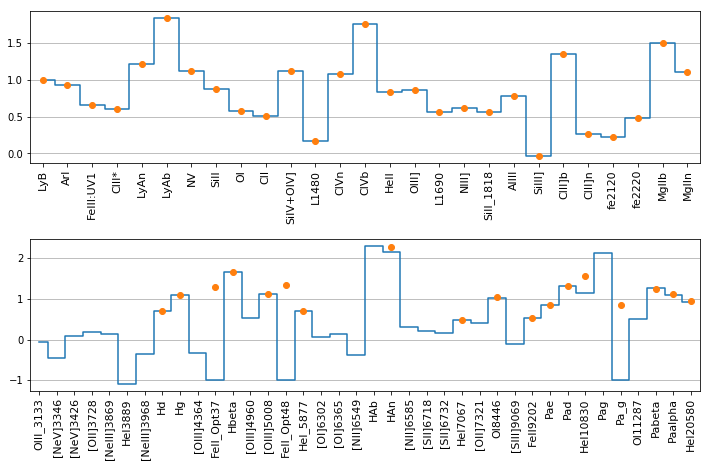

In [8]:
figure(figsize=(12,7))
ax = subplot(211)
ii = where(v6tov5['wave'] < 2900)[0]
plot(ii,v6tov5['logew_v6'][ii],drawstyle='steps-mid')
plot(ii,v6tov5['logew_v5'][ii],'o')
ax.xaxis.set_ticks(ii)
ax.xaxis.set_ticklabels(v6tov5['name'][ii],rotation='vertical',size=11)
ax.grid(axis='y')
xlim(ii[0]-0.5,ii[-1]+0.5)
ax = subplot(212)
ii = where(v6tov5['wave'] > 2900)[0]
plot(ii,v6tov5['logew_v6'][ii].filled(-1),drawstyle='steps-mid')
plot(ii,v6tov5['logew_v5'][ii],'o')
ax.xaxis.set_ticks(ii)
ax.xaxis.set_ticklabels(v6tov5['name'][ii],rotation='vertical',size=11)
xlim(ii[0]-0.5,ii[-1]+0.5)
ax.grid(axis='y')
subplots_adjust(hspace=0.5)

In [9]:
def line_index(trends,line):
    return where(trends['name']==line)[0][0]

In [10]:
v7file = '../simqso/data/emlinetrends_v7.fits'
if not os.path.exists(v7file):
    trendsv7 = trendsv6.copy()
    # replace the bad Pa gamma values in v6 with the v5 values from Glikman et al.
    trendsv7[line_index(trendsv7,'Pag')] = trendsv5[line_index(trendsv5,'Pa_g')]
    trendsv7['name'][line_index(trendsv7,'Pa_g')] = 'Pag' # but keep the name for consistency
    # use a single Halpha component, again falling back to v5 from Glikman
    trendsv7[line_index(trendsv7,'HAb')] = trendsv5[line_index(trendsv5,'Halpha')]
    trendsv7.remove_row(line_index(trendsv7,'HAn'))
    # restore the HeI eq width from v5
    trendsv7[line_index(trendsv7,'HeI10830')] = trendsv5[line_index(trendsv5,'HeI_10830')]
    # change some line EWs based on comparison to Jensen et al.
    trendsv7['logEW'][line_index(trendsv7,'LyAb'),:,1] -= 0.1
    trendsv7['logEW'][line_index(trendsv7,'LyAn'),:,1] -= 0.1
    trendsv7['logEW'][line_index(trendsv7,'NV'),:,1] += 0.2
    trendsv7['logEW'][line_index(trendsv7,'CIVb'),:,1] -= 0.1
    trendsv7['logEW'][line_index(trendsv7,'CIVn'),:,1] -= 0.1
    # add some lya forest lines from Moloney & Shull 2014, default is 20% scatter in EW
    def add_line(name,wave,ew,sigma,ewscatter=0.2):
        trendsv7.insert_row(0,(name,[[0,wave]],
                               [[0,log10(ew)],[0,log10((1-ewscatter)*ew)],[0,log10((1+ewscatter)*ew)]],
                               [[0,log10(sigma)]]))
    add_line('NIII991',991,2.0,5.0)
    add_line('CIII977',985.46,6.55,8.95) # actually from VdB composite
    add_line('Lyepsdel',940.93,2.95,4.73) # ditto
    add_line('OII+OIII833',833,3.14,5)
    add_line('NeVIIIcomplex',773,11.73,10)
    add_line('OIII702',702,2.13,5)
    add_line('NIII686',686,4.16,5)
    add_line('OV629',629,6.55,5)
    # increase LyB+OVI (and rename) to better match MS14
    trendsv7['logEW'][line_index(trendsv7,'LyB'),:,1] += 0.35
    trendsv7['name'][line_index(trendsv7,'LyB')] = 'LyB+OVI'
    trendsv7.write(v7file)
trendsv7 = Table.read(v7file)

In [11]:
emlinesv7 = condense_table(trendsv7)
emlinesv7.show_in_notebook()

idx,name,wave,logew,ew,slope,sigma,scatter
0,OV629,629.0,0.816241,6.55,0.0,0.69897,0.0880456
1,NIII686,686.0,0.619093,4.16,0.0,0.69897,0.0880456
2,OIII702,702.0,0.32838,2.13,0.0,0.69897,0.0880456
3,NeVIIIcomple,773.0,1.0693,11.73,0.0,1.0,0.0880456
4,OII+OIII833,833.0,0.49693,3.14,0.0,0.69897,0.0880456
5,Lyepsdel,940.93,0.469822,2.95,0.0,0.674861,0.0880456
6,CIII977,985.46,0.816241,6.55,0.0,0.951823,0.0880456
7,NIII991,991.0,0.30103,2.0,0.0,0.69897,0.0880456
8,LyB+OVI,1033.83,1.34661,22.2133,0.0488139,0.810857,0.0671692
9,ArI,1068.97,0.926924,8.4513,0.0293174,1.17268,0.0490664


In [12]:
vdblines = generateVdBCompositeEmLines(minEW=0)
vdblines = vdblines(1).squeeze()

In [13]:
def plot_templates():
    figure(figsize=(12,8))
    nsplit = 4
    axes = [ subplot(nsplit,1,n) for n in range(1,nsplit+1) ]
    wave = logspace(log10(700),log10(2.11e4),1200)
    chunks = array_split(arange(len(wave)),nsplit)
    for i in range(len(chunks)-1):
        chunks[i] = np.concatenate([chunks[i],chunks[i+1][:20]])
    for name,emlines,pkwargs in [('VdB',vdblines,dict(c='k',ls='--',lw=2)),
                                 ('v5',emlinesv5,dict(c='C2')),
                                 ('v6',emlinesv6,dict(c='C1')),
                                 ('v7',emlinesv7,dict(c='C0'))]:
        if name == 'VdB':
            linepar = emlines
        else:
            linepar = array([emlines['wave'],emlines['ew'],10**emlines['sigma']]).T
        spec = render_gaussians(wave,0,linepar)
        for i,ii in enumerate(chunks):
            axes[i].plot(wave[ii],1+spec[ii],label=name,**pkwargs)
    for i,ax in enumerate(axes):
        ax.set_xlim(wave[chunks[i][0]],wave[chunks[i][-1]])
        ax.set_yscale('log')
        ax.xaxis.set_major_locator(ticker.LinearLocator(12))
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    legend()

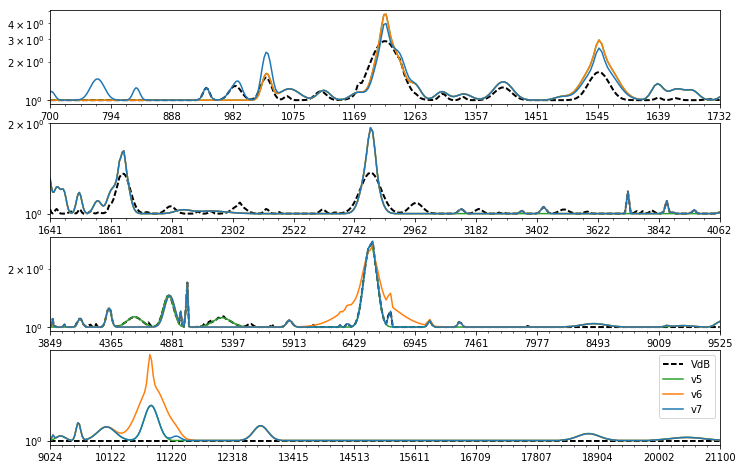

In [14]:
plot_templates()

## Comparison to Jensen et al. composite spectra

In [15]:
# download from here http://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=composite-spectra-of-quasars-binned-on-spectroscopic-parameters-from-dr12q/
comps = Table.read('QSO_comps.fits')
# these are parameters for a conversion from Lbol vs. M1350, using BC(1350)=4 as in Jensen et al.
Lbolconv = array([-2.5,91.4662])
Lbolbins = array([45.93,46.25,46.63]) # roughly the average low,mid,hi Lbol values from Jensen+
M1350bins = polyval(Lbolconv,Lbolbins)

In [16]:
from simqso.sqbase import fixed_R_dispersion
from simqso.sqrun import buildQsoSpectrum
from simqso.sqmodels import BossDr9_FeScalings
from simqso.sqgrids import *
wave = fixed_R_dispersion(800,1e4,500)
M = AbsMagVar(FixedSampler(M1350bins),restWave=1350)
z = RedshiftVar(FixedSampler([0.0]*len(M1350bins)))
qsos = QsoSimPoints([M,z],cosmo=None,units='luminosity')
contVar = BrokenPowerLawContinuumVar([ConstSampler(-1.5),ConstSampler(-0.5)],[1190.])
emLineVar = generateBEffEmissionLines(qsos.absMag,NoScatter=True,
                                      EmissionLineTrendFilename='emlinetrends_v7',verbose=10)
feVar = FeTemplateVar(VW01FeTemplateGrid(qsos.z,wave,scales=BossDr9_FeScalings))
qsos.addVars([contVar,emLineVar,feVar])
spec = [ buildQsoSpectrum(wave,None,qsos.getVars(SpectralFeatureVar),dat) for dat in qsos.data ]

loading emission line template emlinetrends_v7


In [17]:
def norm_at(wave,spec,normwave):
    i1,i2 = searchsorted(wave,[normwave-10,normwave+10])
    return spec/median(spec[i1:i2])

In [18]:
def compare_jensen(spec,comps,compname):
    sqspec = norm_at(spec.wave,spec.f_lambda,1450)
    cspec = norm_at(comps['BASEWAVE'],comps[compname],1450)
    figure(figsize=(12,7))
    waves = [(950,1750),(1750,3000)]
    for pnum,(w1,w2) in enumerate(waves,start=1):
        subplot(2,1,pnum)
        ii = where( (spec.wave>w1) & (spec.wave<w2) )[0]
        plot(spec.wave[ii],sqspec[ii],label='simqso')
        ii = where( (comps['BASEWAVE']>w1) & (comps['BASEWAVE']<w2) )[0]
        plot(comps['BASEWAVE'][ii],cspec[ii],label='Jensen+')
        xlim(w1,w2)
        ylim(-0.1,ylim()[1])
    legend()

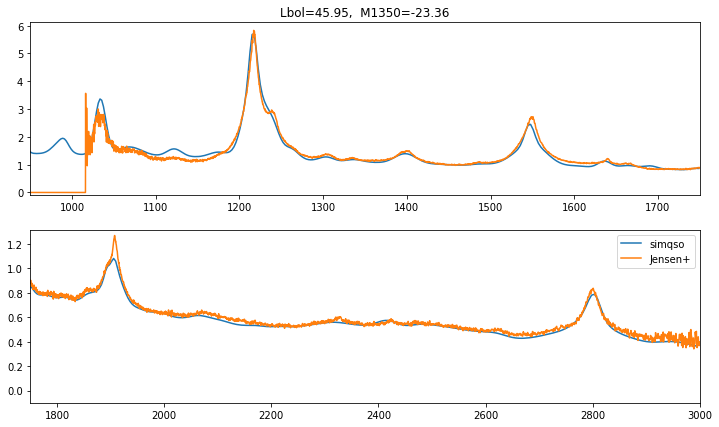

In [19]:
compare_jensen(spec[0],comps,'COMP11')
gcf().axes[0].set_title('Lbol=45.95,  M1350=%.2f'%M1350bins[0]);

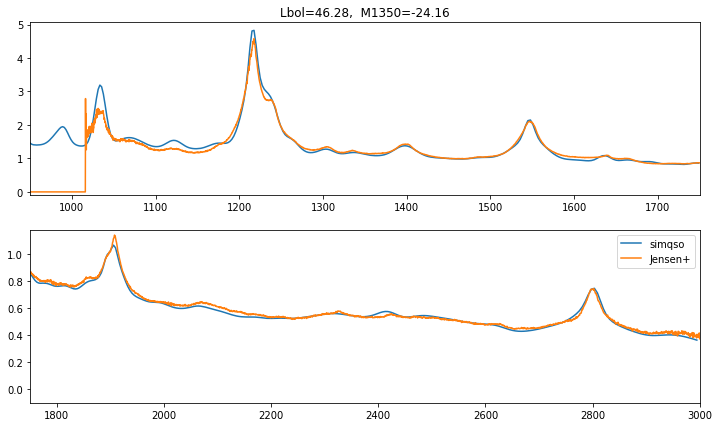

In [20]:
compare_jensen(spec[1],comps,'COMP14')
gcf().axes[0].set_title('Lbol=46.28,  M1350=%.2f'%M1350bins[1]);

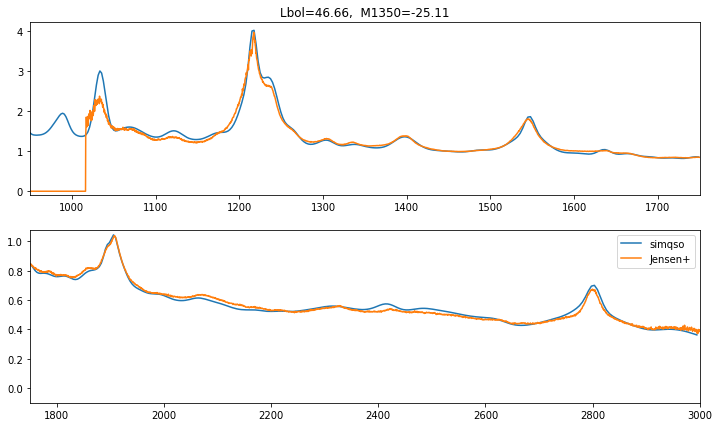

In [21]:
compare_jensen(spec[2],comps,'COMP17')
gcf().axes[0].set_title('Lbol=46.66,  M1350=%.2f'%M1350bins[2]);

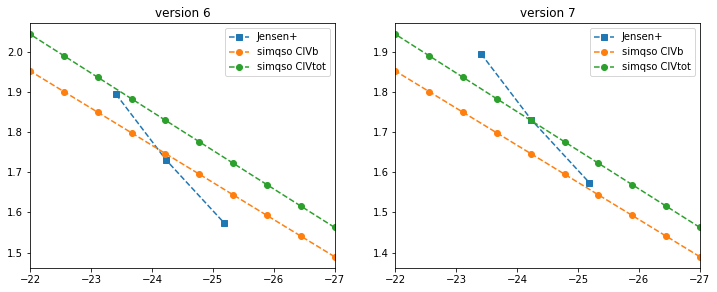

In [22]:
loglbol = array([45.95,46.28,46.66])
logcivew = array([1.894,1.730,1.574])
m1350 = polyval(Lbolconv,loglbol)
def compare_CIV_EW(trends,emlines):
    li = line_index(trends,'CIVb')
    li2 = line_index(trends,'CIVn')
    m1350sq = linspace(-27,-22,10)
    M1450 = m1350sq
    M_i = M1450 - 1.486 + 0.596
    logcivewsq = emlines['logew'][li] + emlines['slope'][li]*(M_i+25)
    logcivew2sq = emlines['logew'][li2] + emlines['slope'][li2]*(M_i+25)
    logtotcivewsq = log10(np.sum(np.power(10,[logcivewsq,logcivew2sq]),axis=0))
    plot(m1350,logcivew,'s--',label='Jensen+')
    plot(m1350sq,logcivewsq,'o--',label='simqso CIVb')
    plot(m1350sq,logtotcivewsq,'o--',label='simqso CIVtot')
    xlim(-22,-27)
    legend();
figure(figsize=(12,4.5))
subplot(121)
compare_CIV_EW(trendsv6,emlinesv6)
title('version 6')
subplot(122)
compare_CIV_EW(trendsv7,emlinesv7)
title('version 7');